In [2]:
import sys
import os
import shutil

_module_path = os.path.abspath("../../")
print(_module_path)
sys.path.append(_module_path)

c:\Users\86994\Desktop\camera_kit


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from calibration_libs.ccalibration import CCameraCalibration


In [4]:
from calibration_libs.utils import get_chess_corners, get_chess_corners_world, img_to_world_by_dis, world_to_img_l, vis_disparity

In [5]:
def clear_folder(folder):
    for name in os.listdir(folder):
        path = os.path.join(folder, name)
        if os.path.isfile(path) or os.path.islink(path):
            os.remove(path)
        elif os.path.isdir(path):
            shutil.rmtree(path)

In [6]:
images_path =  os.path.abspath('./images_640x480')

In [7]:
# 标定板参数
chessSize=[11, 8] # col, row, 长边设置为col, 短边row , col作为x轴， row作为y轴
chessCellLen=20 # 单位 mm

In [8]:
#相机标定类
mycc = CCameraCalibration()  #初始化
mycc.set_calibration_images(images_path, 15, 480, 1280, size=chessSize, length=chessCellLen) #设置标定图像的路径和图片数量

['WIN_20251207_14_54_12_Pro.jpg', 'WIN_20251207_14_54_42_Pro.jpg', 'WIN_20251207_14_54_48_Pro.jpg', 'WIN_20251207_14_54_55_Pro.jpg', 'WIN_20251207_14_55_08_Pro.jpg', 'WIN_20251207_14_55_13_Pro.jpg', 'WIN_20251207_14_55_20_Pro.jpg', 'WIN_20251207_14_55_26_Pro.jpg', 'WIN_20251207_14_55_45_Pro.jpg', 'WIN_20251207_14_55_53_Pro.jpg', 'WIN_20251207_14_56_02_Pro.jpg', 'WIN_20251207_14_56_07_Pro.jpg', 'WIN_20251207_14_56_32_Pro.jpg', 'WIN_20251207_14_56_40_Pro.jpg', 'WIN_20251207_14_56_44_Pro.jpg', 'WIN_20251207_14_56_48_Pro.jpg', 'WIN_20251207_14_57_01_Pro.jpg', 'WIN_20251207_14_57_06_Pro.jpg', 'WIN_20251207_14_57_11_Pro.jpg', 'WIN_20251207_14_57_16_Pro.jpg']


In [9]:
mycc.stereo_calibration(True, reversal=False) #进行双目立体标定，得到内参矩阵、畸变系数、重映射矩阵map、重投影矩阵Q等
mycc.print_p()

you have calibrated !
左图对应相机的内参..................................
[[338.65445417   0.         294.63245868]
 [  0.         338.79315821 235.99560417]
 [  0.           0.           1.        ]]

右图对应相机的内参..................................
[[338.19616913   0.         279.11848074]
 [  0.         338.04469341 231.75555723]
 [  0.           0.           1.        ]]

重投影矩阵Q..................................
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -2.93751724e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.42089602e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.38418926e+02]
 [ 0.00000000e+00  0.00000000e+00  1.65904301e-02 -0.00000000e+00]]


In [10]:
# 批量生成校正图，以给其它算法使用, 包括 merge、left、right
if False:
    _valid_extensions = {'.jpg', '.png', '.bmp', '.jpeg', '.gif'}
    _image_files = []

    for _item_name in os.listdir(images_path):
        _full_path = os.path.join(images_path, _item_name)
        if os.path.isfile(_full_path):
            _root, _ext = os.path.splitext(_item_name)
            if _ext.lower() in _valid_extensions:
                _image_files.append(_item_name)

    _left_path = "./imgs_left_rectify"; os.makedirs(_left_path, exist_ok=True)
    _right_path = "./imgs_right_rectify"; os.makedirs(_right_path, exist_ok=True)
    _merge_path = "./imgs_merge_rectify"; os.makedirs(_merge_path, exist_ok=True)

    clear_folder(_left_path)
    clear_folder(_right_path)
    clear_folder(_merge_path)

    print(_image_files)
    for _img_name in _image_files:
        img_merge = cv2.imread(os.path.join(images_path, _img_name), 1)
        _height, _width, _c = img_merge.shape
        _left_src = img_merge[:, 0: _width//2] #拆分左右图像
        _right_src = img_merge[:, _width//2:]

        _left_rectify = cv2.remap(_left_src, mycc._leftParameters["map1"], mycc._leftParameters["map2"], cv2.INTER_LINEAR)
        _right_rectify = cv2.remap(_right_src, mycc._rightParameters["map1"], mycc._rightParameters["map2"], cv2.INTER_LINEAR)
        _img_merge_rectify =  cv2.hconcat([_left_rectify, _right_rectify]) #合并校正后图像

        _save_name = _img_name.split('.')[0] + ".png" # 以png保存
        cv2.imwrite(os.path.join(_left_path, _save_name), _left_rectify)
        cv2.imwrite(os.path.join(_right_path, _save_name), _right_rectify)
        cv2.imwrite(os.path.join(_merge_path, _save_name), _img_merge_rectify)


图像形状: (480, 1280, 3)


Text(0.5, 1.0, 'Remap')

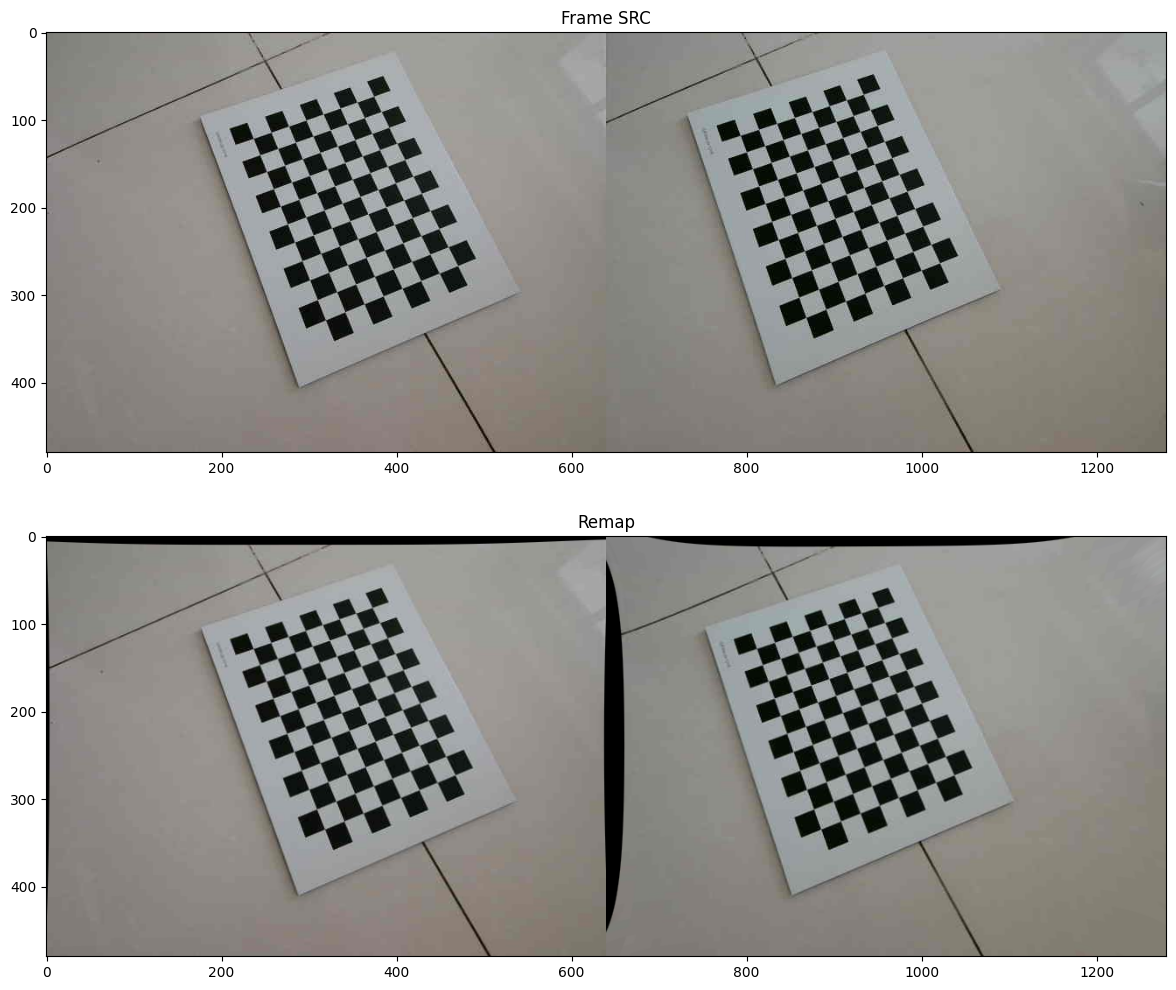

In [11]:
# 立体校正
img_src = cv2.imread('./images_640x480/WIN_20251207_14_54_12_Pro.jpg')
print("图像形状:", img_src.shape)
_height, _width, _c = img_src.shape
left_src = img_src[:, 0: _width//2] #拆分左右图像
right_src = img_src[:, _width//2:]

#立体校正
left_remap = cv2.remap(left_src, mycc._leftParameters["map1"], mycc._leftParameters["map2"], cv2.INTER_LINEAR)
right_remap = cv2.remap(right_src, mycc._rightParameters["map1"], mycc._rightParameters["map2"], cv2.INTER_LINEAR)
img_remap =  cv2.hconcat([left_remap, right_remap]) #合并校正后图像

plt.figure(figsize=(16,12))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))
plt.title("Frame SRC")   # 左图标题

plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(img_remap, cv2.COLOR_BGR2RGB))
plt.title("Remap")   # 左图标题

In [12]:
# 对齐校验

In [13]:
_ret, left_src_corners, _left_src_corners_draw = get_chess_corners(left_src, chessSize, draw_flag=True)
_ret, right_src_corners, _right_src_corners_draw = get_chess_corners(right_src, chessSize, draw_flag=True)
_src_draw_concat = cv2.hconcat([_left_src_corners_draw, _right_src_corners_draw]) #合并绘图

# remap 图
_ret, left_remap_corners, _left_remap_corners_draw = get_chess_corners(left_remap, chessSize, draw_flag=True)
_ret, right_remap_corners, _right_remap_corners_draw = get_chess_corners(right_remap, chessSize, draw_flag=True)
_remap_draw_concat = cv2.hconcat([_left_remap_corners_draw, _right_remap_corners_draw]) #合并绘图

Text(0.5, 1.0, 'Remap')

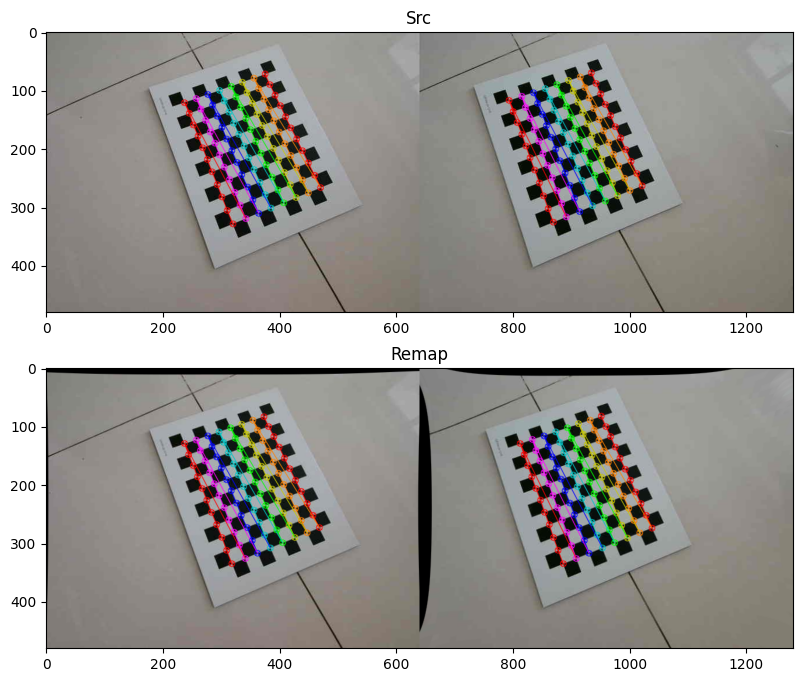

In [14]:
# 角点检测图
plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(_src_draw_concat, cv2.COLOR_BGR2RGB))
plt.title("Src")  

plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(_remap_draw_concat, cv2.COLOR_BGR2RGB))
plt.title("Remap")

原图在y坐标上的总误差(绝对值之和):  26.599594
Remap校正图在y坐标上的总误差(绝对值之和):  0.83558655


Text(0.5, 1.0, 'Remap')

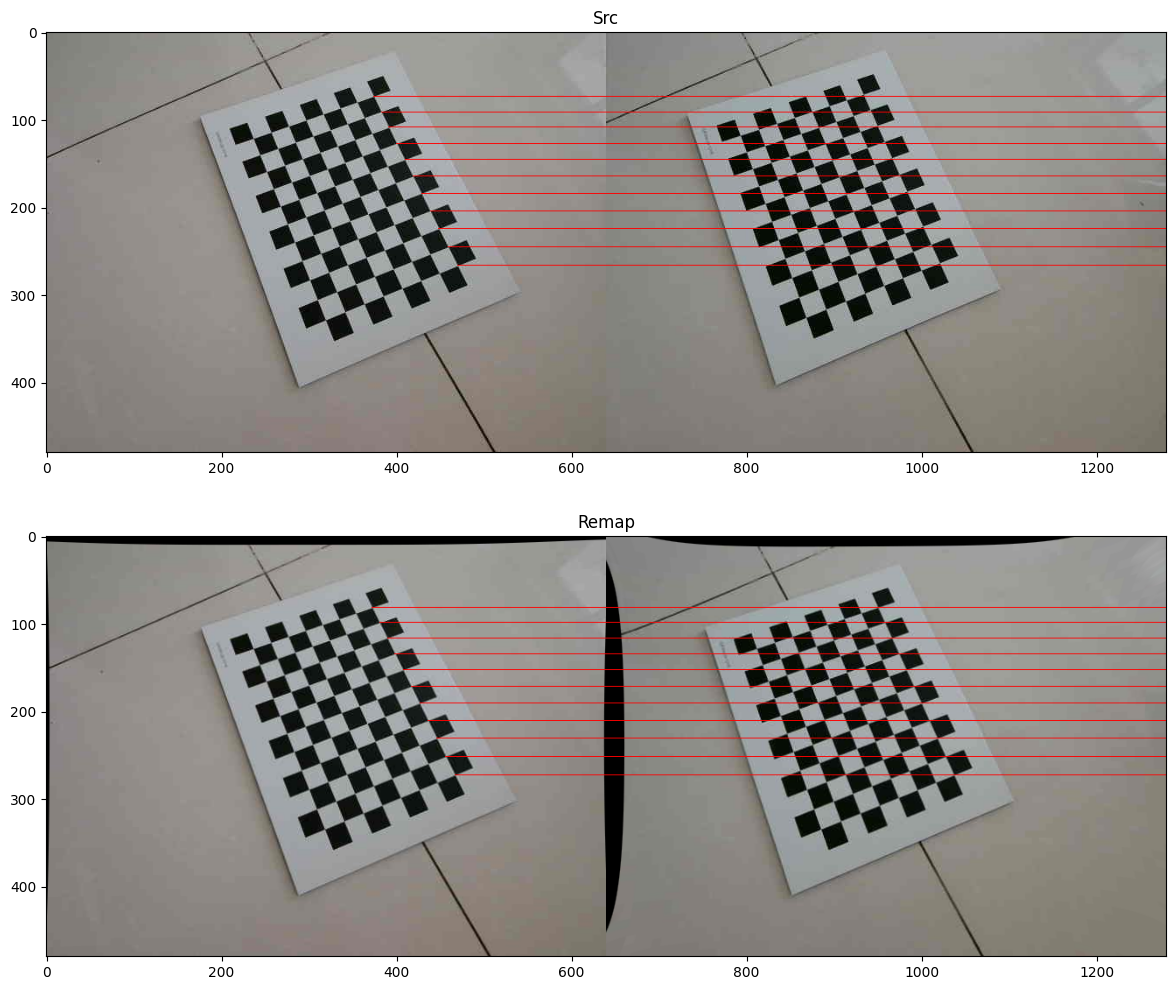

In [15]:
# 绘制水平线，挑选长边竖直的图像绘制
## 原图
_draw_src = img_src.copy()
_width = _draw_src.shape[1]
_points_src_left = left_src_corners[:chessSize[0],:,:] # shape: (col 1 2)
_points_src_right = right_src_corners[:chessSize[0],:,:] # shape: (col 1 2)

_src_error = 0.0
for _point_left, _point_right in zip(_points_src_left, _points_src_right):
    _pt1 = (int(_point_left[0][0]), int(_point_left[0][1]))
    _pt2 = (_width-1, int(_point_left[0][1]))
    _src_error += abs(_point_left[0][1] - _point_right[0][1])
    cv2.line(_draw_src, _pt1, _pt2, (0,0,255), thickness=1)
print("原图在y坐标上的总误差(绝对值之和): ", _src_error)

## remap后
_draw_remap = img_remap.copy()
_width = img_remap.shape[1]
_points_remap_left = left_remap_corners[:chessSize[0],:,:] # shape: (col 1 2)
_points_remap_right = right_remap_corners[:chessSize[0],:,:] # shape: (col 1 2)
_remap_error = 0.0
for _point_left, _point_right in zip(_points_remap_left, _points_remap_right):
    _pt1 = (int(_point_left[0][0]), int(_point_left[0][1]))
    _pt2 = (_width-1, int(_point_left[0][1]))
    _remap_error += abs(_point_left[0][1] - _point_right[0][1])
    cv2.line(_draw_remap, _pt1, _pt2, (0,0,255), thickness=1)
print("Remap校正图在y坐标上的总误差(绝对值之和): ", _remap_error)
# 立体校正检测图
plt.figure(figsize=(16,12))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(_draw_src, cv2.COLOR_BGR2RGB))
plt.title("Src")  

plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(_draw_remap, cv2.COLOR_BGR2RGB))
plt.title("Remap")

In [16]:
# 从像素坐标到实际坐标的检验
# 7 个格子
_cell_nums = 7
pt1_left = left_remap_corners[0][0]
pt1_right = right_remap_corners[0][0]
_world_pt1 = img_to_world_by_dis(pt1_left, pt1_left[0]-pt1_right[0], mycc._stereoCommParameters["Q"])
print("真实坐标点1:", _world_pt1)

pt2_left = left_remap_corners[_cell_nums][0]
pt2_right = right_remap_corners[_cell_nums][0]
_world_pt2 = img_to_world_by_dis(pt2_left, pt2_left[0]-pt2_right[0], mycc._stereoCommParameters["Q"])
print("真实坐标点2:", _world_pt2)

print(f"{_cell_nums}个格子的实际距离: {_cell_nums*chessCellLen} mm")
print(f"使用矩阵Q计算得到的距离: {np.linalg.norm(_world_pt2-_world_pt1)} mm")

真实坐标点1: [[  76.86755484 -155.27893854  329.41881723    1.        ]]
真实坐标点2: [[128.19146743 -27.49003279 303.40117273   1.        ]]
7个格子的实际距离: 140 mm
使用矩阵Q计算得到的距离: 140.1465884745139 mm


[[372.71939087  82.56826019  61.92251587   1.        ]]
[[436.7387085  211.42674255  67.23257446   1.        ]]


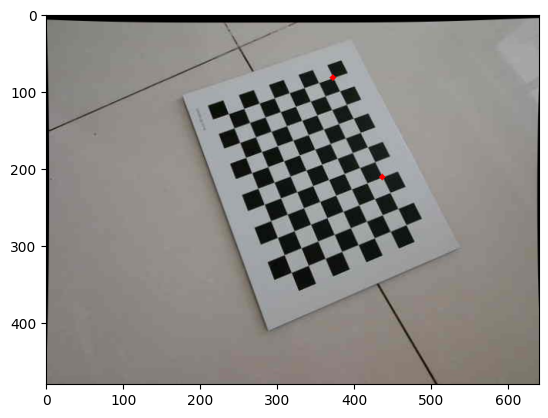

In [17]:
# 实际坐标到像素坐标
_pt1 = world_to_img_l(_world_pt1[0], mycc._stereoCommParameters["Q"])
print(_pt1)

_pt2 = world_to_img_l(_world_pt2[0], mycc._stereoCommParameters["Q"])
print(_pt2)

_draw_cicle = left_remap.copy()
cv2.circle(_draw_cicle, (int(_pt1[0][0]), int(_pt1[0][1])), 2, (0,0,255), 3)
cv2.circle(_draw_cicle, (int(_pt2[0][0]), int(_pt2[0][1])), 2, (0,0,255), 3)

plt.imshow(cv2.cvtColor(_draw_cicle, cv2.COLOR_BGR2RGB))

In [18]:
print(np.linalg.inv(mycc._stereoCommParameters["Q"]))

[[1.00000000e+00 0.00000000e+00 8.68012105e-01 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 7.15354796e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.02757127e+01]
 [0.00000000e+00 0.00000000e+00 2.95491748e-03 0.00000000e+00]]


In [19]:
print(mycc._stereoCommParameters["Q"])

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -2.93751724e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.42089602e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.38418926e+02]
 [ 0.00000000e+00  0.00000000e+00  1.65904301e-02 -0.00000000e+00]]


In [20]:
# SGBM算法初始化
left_matcher  = cv2.StereoSGBM_create(
    minDisparity=0, # 最小视差值。通常为 0，但如果图像经过校正后可能会有偏移，则可能需要调整
    numDisparities=16 * 7, # 最大视差减去最小视差。该值必须大于 0，并且在当前实现中，必须能被 16 整除。设置的视差范围越大，可以检测到的深度范围也越大，但计算量也会增加。
    blockSize=3, # 匹配块的大小 (Matched block size)。它必须是一个 大于等于 1 的奇数。较小保留更多细节，但更容易受噪声影响；较大结果更平滑，但可能丢失细节
    P1=8 * 3 * 3, # 第一个控制视差平滑度的参数。用于计算相邻像素之间视差变化为 1 时的惩罚值
    P2=32 * 3 * 3, # 第二个控制视差平滑度的参数。用于计算相邻像素之间视差变化大于 1 时的惩罚值, 通常，P2 > P1。值越大，得到的视差图越平滑。
    disp12MaxDiff=12, # 左右视差检查的最大容许差值
    uniquenessRatio=10, 
    speckleWindowSize=50, # 用于斑点过滤 (Speckle filtering) 的最大平滑视差区域尺寸
    speckleRange=32, # 斑点过滤中最大允许的视差变化范围, 隐式乘以 16
    preFilterCap=63  # 该值越大，对纹理较少区域的响应越强。
    ) 

# WLS
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher )


In [21]:
grayl = cv2.cvtColor(left_remap, cv2.COLOR_BGR2GRAY)
grayr = cv2.cvtColor(right_remap, cv2.COLOR_BGR2GRAY)

disparity_left  = left_matcher.compute(grayl, grayr)
disparity_right = right_matcher.compute(grayr, grayl)


In [22]:
_dis1 = disparity_left[int(pt1_left[1])][int(pt1_left[0])] /16.0 
_dis1_real = pt1_left[0] - pt1_right[0]
print(f"pt1的stereoSGBM求解视差:{_dis1}, 真实视差:{_dis1_real}")

_dis2 = disparity_left[int(pt2_left[1])][int(pt2_left[0])] /16.0 
_dis2_real = pt2_left[0] - pt2_right[0]
print(f"pt2的stereoSGBM求解视差:{_dis2}, 真实视差:{_dis2_real}")

pt1的stereoSGBM求解视差:62.0625, 真实视差:61.922515869140625
pt2的stereoSGBM求解视差:67.1875, 真实视差:67.23257446289062


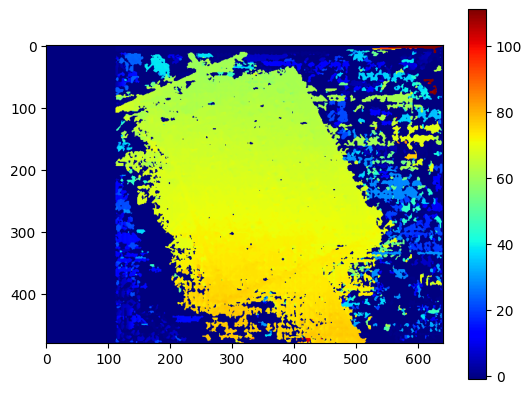

In [41]:
plt.imshow(disparity_left / 16, cmap='jet')
plt.colorbar()
plt.show()

In [24]:
_3dimg = cv2.reprojectImageTo3D(disparity_left, mycc._stereoCommParameters["Q"]) * 16
print(_3dimg.shape)

(480, 640, 3)


In [25]:
print("reprojectImageTo3D点1:", _3dimg[int(pt1_left[1])][int(pt1_left[0])])
_world_pt1 = img_to_world_by_dis(pt1_left, pt1_left[0]-pt1_right[0], mycc._stereoCommParameters["Q"])
print("真实坐标点1:", _world_pt1)

print("reprojectImageTo3D点2:", _3dimg[int(pt2_left[1])][int(pt2_left[0])])
_world_pt1 = img_to_world_by_dis(pt2_left, pt2_left[0]-pt2_right[0], mycc._stereoCommParameters["Q"])
print("真实坐标点2:", _world_pt2)

reprojectImageTo3D点1: [  75.9955  -155.4806   328.67578]
真实坐标点1: [[  76.86755484 -155.27893854  329.41881723    1.        ]]
reprojectImageTo3D点2: [127.61475  -27.891317 303.6047  ]
真实坐标点2: [[128.19146743 -27.49003279 303.40117273   1.        ]]


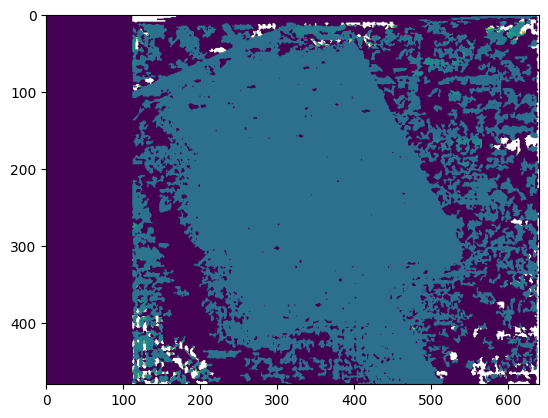

In [26]:
plt.imshow(_3dimg[:,:,2])

In [27]:
# 创建 WLS 滤波器
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(8000)        # 越大越平滑，典型值 800~20000
wls_filter.setSigmaColor(1.5)     # 颜色敏感度 0.8~2 之间

In [28]:
# 执行滤波
# 注意：disparity_filtered 是 float32，单位仍然是 "乘了 16" 的 fixed-point。
disparity_filtered = wls_filter.filter(
    disparity_left, 
    grayl, 
    None,
    disparity_right
)

In [29]:
_dis1 = disparity_filtered[int(pt1_left[1])][int(pt1_left[0])] /16.0 
_dis1_real = pt1_left[0] - pt1_right[0]
print(f"pt1的stereoSGBM求解视差:{_dis1}, 真实视差:{_dis1_real}")

_dis2 = disparity_filtered[int(pt2_left[1])][int(pt2_left[0])] /16.0 
_dis2_real = pt2_left[0] - pt2_right[0]
print(f"pt2的stereoSGBM求解视差:{_dis2}, 真实视差:{_dis2_real}")

pt1的stereoSGBM求解视差:62.0625, 真实视差:61.922515869140625
pt2的stereoSGBM求解视差:67.1875, 真实视差:67.23257446289062


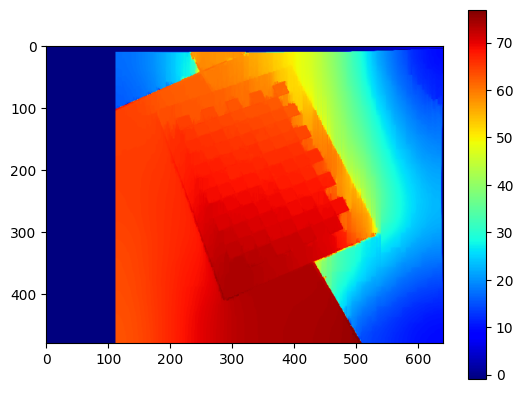

In [40]:
plt.imshow(disparity_filtered / 16, cmap='jet')
plt.colorbar()
plt.show()

In [31]:
_3dimg_filtered = cv2.reprojectImageTo3D(disparity_filtered, mycc._stereoCommParameters["Q"]) * 16
print(_3dimg_filtered.shape)

(480, 640, 3)


In [32]:
print("reprojectImageTo3D点1:", _3dimg_filtered[int(pt1_left[1])][int(pt1_left[0])])
_world_pt1 = img_to_world_by_dis(pt1_left, pt1_left[0]-pt1_right[0], mycc._stereoCommParameters["Q"])
print("真实坐标点1:", _world_pt1)

print("reprojectImageTo3D点2:", _3dimg_filtered[int(pt2_left[1])][int(pt2_left[0])])
_world_pt1 = img_to_world_by_dis(pt2_left, pt2_left[0]-pt2_right[0], mycc._stereoCommParameters["Q"])
print("真实坐标点2:", _world_pt2)

reprojectImageTo3D点1: [  75.9955  -155.4806   328.67578]
真实坐标点1: [[  76.86755484 -155.27893854  329.41881723    1.        ]]
reprojectImageTo3D点2: [127.61475  -27.891317 303.6047  ]
真实坐标点2: [[128.19146743 -27.49003279 303.40117273   1.        ]]


891.7351


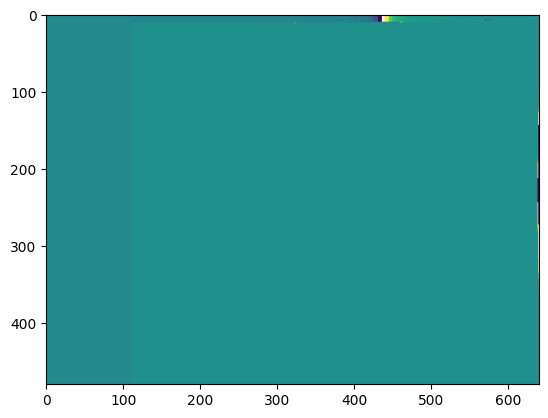

In [39]:
depth = _3dimg_filtered[:,:,2]
# print(depth.max(), depth.min())
print(depth[200][600])
plt.imshow(depth)

In [ ]:
cv2.imshow('1', depth)

: 